In [2]:
#@title Importing dependencies
import time, os
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
import numpy as np
import pandas  as pd
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.models import Model, Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, regularizers
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")


Using TensorFlow backend.


In [0]:
#@title Setting TPU worker
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

In [3]:
#@title Loading the CIFAR-10 dataset & setting class names
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

num_classes = 10
class_names=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse',
             'Ship','Truck']



170500096/170498071 [==============================] - 59s 0us/step


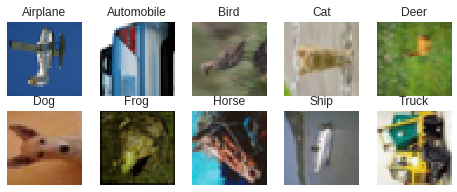

In [4]:
#@title Print figure with ten random images from each class
 
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(2,1,0))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#@title Converting categorial data to dummy variables & normalizing
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255


In [0]:
#@title Defining model creating function & variables
batch_size, epochs = 50, 1000

def base_model():

    inputs = Input(x_train.shape[1:])
    x1 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(inputs)
    x2 = Dropout(0.25)(x1)
    x3 = Conv2D(32, (3, 3), activation = 'relu')(x2)
    x4 = MaxPooling2D(pool_size=(2, 2))(x3)
    x5 = Dropout(0.25)(x4)
    x6 = Conv2D(64, (3, 3), padding='same', activation = 'relu')(x5)
    x7 = Dropout(0.25)(x6)
    x8 = Conv2D(64, (3,3), activation = 'relu')(x7)
    x9 = MaxPooling2D(pool_size=(2, 2))(x8)
    x10 = Dropout(0.25)(x9)
    x11 = Flatten()(x10)
    x12 = Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2())(x11)
    x13 = Dropout(0.5)(x12)
    predictions = Dense(num_classes, activation = 'softmax')(x13)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # Compile the model
    model = Model(inputs = inputs, outputs = predictions)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model


In [0]:
#@title Defining callbacks
class My_Callback(Callback):
    def on_train_begin(self, logs={}):
        print("train begins!")
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        print("-", end='')
        flag_val=True
        if epoch%5==0:
            train_acc = logs.get("acc")
            train_loss = logs.get("loss")
            try:
                val_acc = logs.get("val_acc")
                val_loss = logs.get("val_loss")
            except:
                flag_val=False
            if flag_val:
                print("\n%d"%epoch, "\ttrain_loss: ", train_loss, "\tval_loss: ", val_loss)
            else:
                print("\n%d"%epoch, "\ttrain_loss: ", train_loss)    
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1, mode='auto', min_lr=1e-12)
my_callback = My_Callback()

checkpoint = ModelCheckpoint("CIFAR10_model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)


In [8]:
#@title Creating and fitting the model
cnn_n = base_model()
cnn_n.summary()
try:
  
  tpu_cnn_model = tf.contrib.tpu.keras_to_tpu_model(
    cnn_n,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  cnn_tpu=tpu_cnn_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                  validation_data=(x_test,y_test),shuffle=True,
                 callbacks = [my_callback, reduce_lr, checkpoint],verbose=0)

except:
    cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                  validation_data=(x_test,y_test),shuffle=True,
                 callbacks = [my_callback, reduce_lr, checkpoint],verbose=0)

        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 32, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 30, 30)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 15, 15)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 15, 15)        18496     
__________

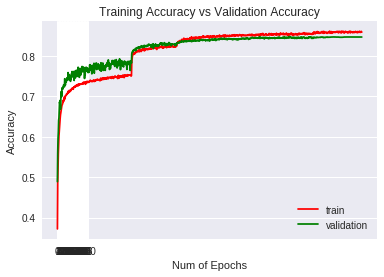

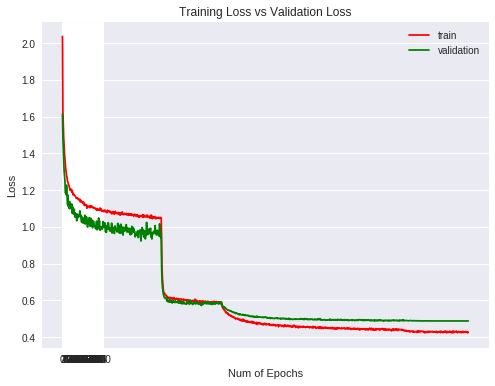

In [9]:
#@title Plotting the training and testing process: loss and accuracy

# Accuracy
plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

# Loss 
plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()


In [0]:
#@title Make predictions of the test set with the trained model 
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)


0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[860   6  30  14  15   1   5  11  46  12]
 [ 11 921   1   4   3   0   3   2  16  39]
 [ 37   0 763  38  65  41  43   8   5   0]
 [ 13   0  41 729  43 101  45  18   4   6]
 [  7   0  34  43 852  14  28  18   4   0]
 [  7   1  25 149  30 758   8  20   1   1]
 [  3   0  25  30  15   9 913   2   2   1]
 [ 13   0  17  32  41  28   1 863   3   2]
 [ 33   9   9  11   0   1   5   2 921   9]
 [ 24  34   4  12   0   3   5   4  27 887]]


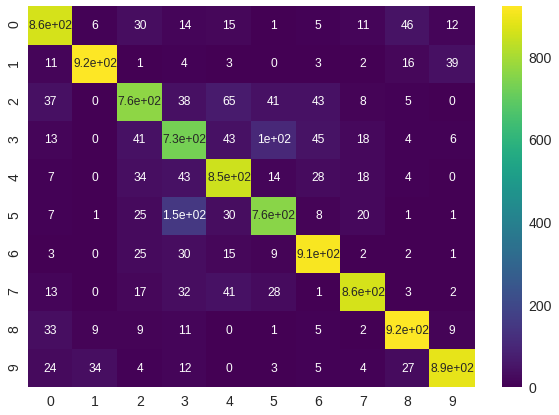

In [12]:
#@title Evaluating the model with confusion matrix & visualizing the confusion matrix
for ix in range(num_classes):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

df_cm = pd.DataFrame(cm, range(num_classes),range(num_classes))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap='viridis', annot=True,annot_kws={"size": 12})# font size
plt.show()

